# An RNN for short-term predictions
This model will try to predict the next value in a short sequence based on historical data. This can be used for example to forecast demand based on a couple of weeks of sales data.

<div class="alert alert-block alert-info">
This version packages the model into an Estimator interface.
It can be executed on Google cloud ML Engine using the code in this bash notebook: [../run-on-cloud-ml-engine.ipynb](../run-on-cloud-ml-engine.ipynb)
</div>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python.platform import tf_logging as logging
logging.set_verbosity(logging.INFO)
logging.log(logging.INFO, "Tensorflow version " + tf.__version__)
import utils_datagen

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
INFO:tensorflow:Tensorflow version 1.12.0-dev20181009


In [2]:
from matplotlib import pyplot as plt
import utils_display

## Generate fake dataset

In [3]:
DATA_SEQ_LEN = 1024*128
data = np.concatenate([utils_datagen.create_time_series(waveform, DATA_SEQ_LEN) for waveform in utils_datagen.Waveforms])

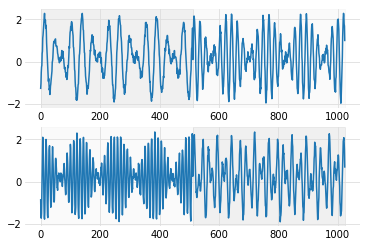

In [4]:
utils_display.picture_this_1(data, DATA_SEQ_LEN)

## Hyperparameters

In [5]:
RNN_CELLSIZE = 32    # size of the RNN cells
SEQLEN = 16         # unrolled sequence length
BATCHSIZE = 32      # mini-batch size

## Visualize training sequences
This is what the neural network will see during training.

Tensor shape of a batch of training sequences: (32, 16)
Random excerpt:


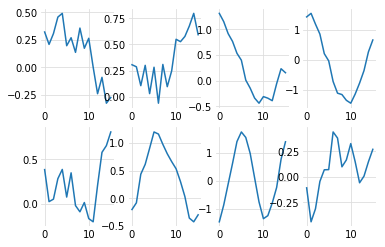

In [6]:
utils_display.picture_this_2(data, BATCHSIZE, SEQLEN) # execute multiple times to see different sample sequences

## The model definition
When executed, this function instantiates the Tensorflow graph for our model.
![deep RNN schematic](images/RNN1.svg)

In [7]:
# tree simplistic predictive models: can you beat them ?
def simplistic_models(X):
    # "random" model
    Yrnd = tf.random_uniform([tf.shape(X)[0]], -2.0, 2.0) # tf.shape(X)[0] is the batch size
    # "same as last" model
    Ysal = X[:,-1]
    # "trend from last two" model
    Ytfl = X[:,-1] + (X[:,-1] - X[:,-2])
    return Yrnd, Ysal, Ytfl

In [10]:
def bad_model(X):
    Yr = X * tf.Variable(tf.ones([]), name="dummy") # shape [BATCHSIZE, SEQLEN]
    Yout = Yr[:,-1:SEQLEN] # Last item in sequence. Yout [BATCHSIZE, 1]
    return Yout

In [11]:
# linear model (RMSE: 0.36, with shuffling: 0.17)
def linear_model(X):
    Yout = tf.layers.dense(X, 1) # output shape [BATCHSIZE, 1]
    return Yout

In [12]:
# 2-layer dense model (RMSE: 0.38, with shuffling: 0.15-0.18)
def DNN_model(X):
    Y = tf.layers.dense(X, SEQLEN//2, activation=tf.nn.relu)
    Yout = tf.layers.dense(Y, 1, activation=None) # output shape [BATCHSIZE, 1]
    return Yout

In [15]:
print(101//2)

50


In [16]:
# convolutional (RMSE: 0.31, with shuffling: 0.16)
def CNN_model(X): 
    X = tf.expand_dims(X, axis=2) # [BATCHSIZE, SEQLEN, 1] is necessary for conv model
    Y = tf.layers.conv1d(X, filters=8, kernel_size=4, activation=tf.nn.relu, padding="same") # [BATCHSIZE, SEQLEN, 8]
    Y = tf.layers.conv1d(Y, filters=16, kernel_size=3, activation=tf.nn.relu, padding="same") # [BATCHSIZE, SEQLEN, 8]
    Y = tf.layers.conv1d(Y, filters=8, kernel_size=1, activation=tf.nn.relu, padding="same") # [BATCHSIZE, SEQLEN, 8]
    Y = tf.layers.max_pooling1d(Y, pool_size=2, strides=2)  # [BATCHSIZE, SEQLEN//2, 8]
    Y = tf.layers.conv1d(Y, filters=8, kernel_size=3, activation=tf.nn.relu, padding="same")  # [BATCHSIZE, SEQLEN//2, 8]
    Y = tf.layers.max_pooling1d(Y, pool_size=2, strides=2)  # [BATCHSIZE, SEQLEN//4, 8]
    # mis-using a conv layer as linear regression :-)
    Yout = tf.layers.conv1d(Y, filters=1, kernel_size=SEQLEN//4, activation=None, padding="valid") # output shape [BATCHSIZE, 1, 1]
    Yout = tf.squeeze(Yout, axis=-1) # output shape [BATCHSIZE, 1]
    return Yout

In [17]:
# RNN model (RMSE: 0.38, with shuffling 0.14, the same with loss on last 8)
def RNN_model(X, n=1):
    # 2-layer RNN
    X = tf.expand_dims(X, axis=2) # [BATCHSIZE, SEQLEN, 1] is necessary for RNN model
    cell1 = tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE)
    cell2 = tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE)
    cell = tf.nn.rnn_cell.MultiRNNCell([cell1, cell2], state_is_tuple=False)
    Yn, H = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32) # Yn [BATCHSIZE, SEQLEN, RNN_CELLSIZE]
    
    # regression head
    batchsize = tf.shape(X)[0]
    Yn = tf.reshape(Yn, [batchsize*SEQLEN, RNN_CELLSIZE])
    Yr = tf.layers.dense(Yn, 1) # Yr [BATCHSIZE*SEQLEN, 1]
    Yr = tf.reshape(Yr, [batchsize, SEQLEN, 1]) # Yr [BATCHSIZE, SEQLEN, 1]
    
    # In this RNN model, you can compute the loss on the last predicted item or the lats n predicted items
    # Last n is slightly better.
    Yout = Yr[:,-n:SEQLEN,:] # last item(s) in sequence: output shape [BATCHSIZE, n, 1]
    Yout = tf.squeeze(Yout, axis=-1)
    return Yout

In [18]:
def RNN_model_N(X): return RNN_model(X, n=SEQLEN//2)

In [19]:
def configurable_model_fn(features, labels, mode, model=CNN_model):
    X = features # shape [BATCHSIZE, SEQLEN]
    Y = model(X)
    Yout = Y[:,-1]
    
    loss = train_op = eval_metrics = None
    if mode != tf.estimator.ModeKeys.PREDICT:
        last_label = labels[:, -1] # last item in sequence: the target value to predict
        last_labels = labels[:, -tf.shape(Y)[1]:SEQLEN] # last p items in sequence (as many as in Y), useful for RNN_model(X, n>1)

        loss = tf.losses.mean_squared_error(Y, last_labels) # loss computed on last label(s)
        optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
        train_op = tf.contrib.training.create_train_op(loss, optimizer)
        #train_op = optimizer.minimize(loss)
        Yrnd, Ysal, Ytfl = simplistic_models(X)
        eval_metrics = {"RMSE": tf.metrics.root_mean_squared_error(Y, last_labels),
                        # compare agains three simplistic predictive models: can you beat them ?
                        "RMSErnd": tf.metrics.root_mean_squared_error(Yrnd, last_label),
                        "RMSEsal": tf.metrics.root_mean_squared_error(Ysal, last_label),
                        "RMSEtfl": tf.metrics.root_mean_squared_error(Ytfl, last_label)}

    return tf.estimator.EstimatorSpec(
        mode = mode,
        predictions = {"Yout":Yout},
        loss = loss,
        train_op = train_op,
        eval_metric_ops = eval_metrics
    )

In [ ]:
def model_fn(features, labels, mode): return configurable_model_fn(features, labels, mode, model=RNN_model_N)

# prepare training dataset

In [ ]:
# training to predict the same sequence shifted by one (next value)
labeldata = np.roll(data, -1)
# slice data into sequences
traindata = np.reshape(data, [-1, SEQLEN])
labeldata = np.reshape(labeldata, [-1, SEQLEN])

# also make an evaluation dataset by randomly subsampling our fake data
EVAL_SEQUENCES = DATA_SEQ_LEN*4//SEQLEN//4
joined_data = np.stack([traindata, labeldata], axis=1) # new shape is [N_sequences, 2(train/eval), SEQLEN]
joined_evaldata = joined_data[np.random.choice(joined_data.shape[0], EVAL_SEQUENCES, replace=False)]
evaldata = joined_evaldata[:,0,:]
evallabels = joined_evaldata[:,1,:]

def train_dataset():
    # Dataset API for batching, shuffling, repeating
    dataset = tf.data.Dataset.from_tensor_slices((traindata, labeldata))
    dataset = dataset.repeat() # indefinitely
    dataset = dataset.shuffle(DATA_SEQ_LEN*4//SEQLEN) # important ! Number of sequences in shuffle buffer: all of them
    dataset = dataset.batch(BATCHSIZE)
    
    samples, labels = dataset.make_one_shot_iterator().get_next()
    return samples, labels

def eval_dataset():
    # Dataset API for batching
    evaldataset = tf.data.Dataset.from_tensor_slices((evaldata, evallabels))
    evaldataset = evaldataset.repeat(1)
    evaldataset = evaldataset.batch(EVAL_SEQUENCES) # just one batch with everything

    samples, labels = evaldataset.make_one_shot_iterator().get_next()
    return samples, labels

In [ ]:
NB_EPOCHS = 5
nbsteps = DATA_SEQ_LEN*4//SEQLEN//BATCHSIZE * NB_EPOCHS
train_spec = tf.estimator.TrainSpec(input_fn=train_dataset, max_steps=nbsteps)
eval_spec = tf.estimator.EvalSpec(input_fn=eval_dataset, throttle_secs=20, start_delay_secs=1, steps=None) # eval until dataset exhausted (1 batch)
training_config = tf.estimator.RunConfig(model_dir="./outputdir")
estimator=tf.estimator.Estimator(model_fn=model_fn, config=training_config)
tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

In [ ]:
evals = estimator.evaluate(eval_dataset)
results = estimator.predict(eval_dataset)
Yout_ = [result["Yout"] for result in results]
utils_display.picture_this_3(Yout_, evaldata, evallabels, SEQLEN) # execute multiple times to see different sample sequences

Copyright 2018 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
[http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.